In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime,timedelta
import geopandas as gpd

#### County level confirmed cases and deaths

In [97]:
nyt = pd.read_csv('New_York_Times/us-counties.csv')
nyt.sample(5)

,date,county,state,fips,cases,deaths
98307,2020-04-29,Mobile,Alabama,1097.0,1041,53
1275,2020-03-11,Hudson,New Jersey,34017.0,1,0
14138,2020-03-27,Hempstead,Arkansas,5057.0,1,0
14664,2020-03-27,Menifee,Kentucky,21165.0,2,0
55066,2020-04-13,Otter Tail,Minnesota,27111.0,4,0


In [98]:
nyt.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0
1,2020-01-22,Snohomish,Washington,53061.0,1,0
2,2020-01-23,Snohomish,Washington,53061.0,1,0
3,2020-01-24,Cook,Illinois,17031.0,1,0
4,2020-01-24,Snohomish,Washington,53061.0,1,0


#### Constants for the notebook

In [99]:
test_end_date = datetime.strptime("2020-05-05","%Y-%m-%d")
total_sample_time = 8 

In [100]:
sample_dates_for_test = [test_end_date - timedelta(days=diff) for diff in range(total_sample_time)]

In [5]:
nyt['date'] = nyt.apply(lambda row: datetime.strptime(row['date'],"%Y-%m-%d"),axis=1)
nyt.fips.fillna("00000",inplace=True)

In [6]:
nyt = nyt[(nyt['date'].isin(sample_dates_for_test)) & (nyt.state == 'New York')]
nyt['county_fips'] = nyt.apply(lambda row: int(row['fips'])%1000 ,axis=1)
nyt.reset_index(drop=True,inplace=True)
nyt.head()

,date,county,state,fips,cases,deaths,county_fips
0,2020-04-28,Albany,New York,36001,1009,45,1
1,2020-04-28,Allegany,New York,36003,35,0,3
2,2020-04-28,Broome,New York,36007,266,15,7
3,2020-04-28,Cattaraugus,New York,36009,45,1,9
4,2020-04-28,Cayuga,New York,36011,48,1,11


#### county level census data

In [7]:
county_pop = pd.read_csv('county_population.csv')
county_pop = county_pop[(county_pop['YEAR'] == 11) & (county_pop['AGEGRP'] == 0)]
county_pop.sample(5)

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,AGEGRP,TOT_POP,TOT_MALE,TOT_FEMALE,...,HWAC_MALE,HWAC_FEMALE,HBAC_MALE,HBAC_FEMALE,HIAC_MALE,HIAC_FEMALE,HAAC_MALE,HAAC_FEMALE,HNAC_MALE,HNAC_FEMALE
11685,50,36,111,New York,Ulster County,11,0,178599,88505,90094,...,8443,7566,1461,1338,344,309,118,100,46,60
6669,50,36,63,New York,Niagara County,11,0,210433,102493,107940,...,2794,2764,434,533,179,188,35,32,16,39
399,50,36,3,New York,Allegany County,11,0,46430,23569,22861,...,341,303,58,53,35,34,14,5,4,7
1862,50,36,17,New York,Chenango County,11,0,47536,23814,23722,...,501,426,48,52,35,32,9,8,4,1
12103,50,36,115,New York,Washington County,11,0,61197,31674,29523,...,885,474,313,46,68,43,19,8,8,3


#### Merging the census data with county level cases data

In [8]:
county_tot_pop = county_pop[['COUNTY','TOT_POP']]
nyc_tot_pop = county_pop[county_pop.CTYNAME.isin(['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County'])]['TOT_POP'].sum()
nys_merged = pd.merge(nyt,county_tot_pop,how='left',left_on='county_fips',right_on='COUNTY')
nys_merged.drop('COUNTY',inplace=True,axis=1)
nys_merged.TOT_POP.fillna(nyc_tot_pop,inplace=True)
nys_merged.sort_values(by=['county','date'],ascending=True,inplace=True)
nys_merged.reset_index(drop=True,inplace=True)
nys_merged.sample(5)

,date,county,state,fips,cases,deaths,county_fips,TOT_POP
114,2020-04-30,Essex,New York,36031,34,0,31,37300.0
34,2020-04-30,Cayuga,New York,36011,48,1,11,77145.0
142,2020-05-04,Genesee,New York,36037,159,2,37,57511.0
232,2020-04-28,Niagara,New York,36063,386,11,63,210433.0
207,2020-05-05,Monroe,New York,36055,1624,101,55,742474.0


#### calculating infected rate, recovery rate and $R_{o}$

In [ ]:
nys_merged['roll_diff'] = nys_merged.groupby(['county'])['cases'].diff()
nys_merged['infected_rate'] = nys_merged.roll_diff / nys_merged.cases.shift(1) * 100
nys_merged.dropna(inplace=True)
nys_merged['recovery_rate'] = 1-(nys_merged.deaths/nys_merged.cases)
nys_merged['r_naught'] = nys_merged.infected_rate/nys_merged.recovery_rate
nys_merged.sample(10)

In [10]:
#nys_merged.head(30)

#### Calculating the median $R_{0}$ and infected rate

In [11]:
nys_rnaught = pd.DataFrame(nys_merged.groupby(['county','county_fips']).agg({'r_naught':'median','infected_rate':'mean'}))
nys_rnaught.sample(5)

,,r_naught,infected_rate
county,county_fips,,
Otsego,77,0.000000,0.436230
Livingston,51,3.171598,4.109332
Rensselaer,83,4.678315,4.475141
Putnam,79,1.376249,1.454541
Yates,123,0.000000,1.633987


In [12]:
nys_rnaught.head()

,,r_naught,infected_rate
county,county_fips,,
Albany,1,2.967753,3.652730
Allegany,3,0.000000,0.000000
Broome,7,2.784578,3.500093
Cattaraugus,9,2.082466,2.391511
Cayuga,11,0.000000,0.892857


#### Shape file of counties

In [13]:
counties_shp = gpd.read_file('./NYS_Civil_Boundaries_SHP/Counties.shp')
counties_shp.sample(5)

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
47,Steuben,STEU,974148,36101,460000,Central,99088,98726,98990,0,None,None,N,1404.077923,2019-04-26,259450.272985,3.636545e+09,"POLYGON ((283514.2430999996 4717582.354900001,..."
16,Franklin,FRAN,974115,36033,160000,East,46540,51134,51599,0,None,None,N,1696.382337,2018-10-04,314349.876795,4.393610e+09,"POLYGON ((526445.3464000002 4983199.0765, 5266..."
59,Madison,MADI,974125,36053,250000,Central,69120,69441,73442,0,None,None,N,660.767520,2018-07-18,256920.429764,1.711380e+09,"POLYGON ((419469.2510000002 4781779.49, 419487..."
29,Niagara,NIAG,974130,36063,290000,West,220756,219846,216469,0,None,None,N,1140.646685,2018-03-26,261349.594691,2.954261e+09,"POLYGON ((218080.7357000001 4778395.6011, 2180..."
54,Washington,WASH,974155,36115,530000,East,59330,61042,63216,0,None,None,N,845.855708,2017-11-10,302358.996696,2.190756e+09,"POLYGON ((630545.5016999999 4850934.2498, 6305..."


In [14]:
counties_shp[counties_shp.NAME.isin(['Bronx', 'Queens', 'Richmond', 'New York', 'Kings'])]

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
2,Bronx,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,0,None,None,Y,57.472148,2019-10-04,57253.861278,1.488522e+08,"POLYGON ((595540.6787 4528518.901900001, 59576..."
22,Kings,KING,974122,36047,610000,Long Island,2300664,2465326,2504700,0,None,None,Y,97.145606,2019-10-04,72427.917642,2.516060e+08,"POLYGON ((590578.6771 4508877.912, 590747.1109..."
28,New York,NEWY,974129,36061,620000,Long Island,1487536,1537195,1585873,0,None,None,Y,33.725634,2019-10-04,60023.614235,8.734899e+07,"(POLYGON ((580767.7347999997 4504621.9627, 580..."
37,Queens,QUEE,974139,36081,630000,Long Island,1951598,2229379,2230722,0,None,None,Y,179.512468,2019-10-04,141112.098357,4.649352e+08,"POLYGON ((603175.3032 4518295.4002, 605418.800..."
39,Richmond,RICH,974141,36085,640000,Long Island,378977,443728,468730,0,None,None,Y,102.460854,2019-10-04,67419.775601,2.653724e+08,"POLYGON ((579821.9901000001 4500038.726, 57979..."


In [15]:
temp = pd.DataFrame({'county': ['Bronx', 'Queens', 'Richmond', 'New York', 'Kings'],\
                     'county_fips':[5,47,61,81,85], \
                     'r_naught':[nys_rnaught.loc['New York City']['r_naught'][0]]*5,\
                     'infected_rate':[nys_rnaught.loc['New York City']['infected_rate'][0]]*5\
                    })

In [16]:
temp

,county,county_fips,r_naught,infected_rate
0,Bronx,5,1.427515,1.237326
1,Queens,47,1.427515,1.237326
2,Richmond,61,1.427515,1.237326
3,New York,81,1.427515,1.237326
4,Kings,85,1.427515,1.237326


In [17]:
nys_rnaught = nys_rnaught.drop(index='New York City')
nys_rnaught.reset_index(inplace=True)
nys_rnaught.head(5)

,county,county_fips,r_naught,infected_rate
0,Albany,1,2.967753,3.652730
1,Allegany,3,0.000000,0.000000
2,Broome,7,2.784578,3.500093
3,Cattaraugus,9,2.082466,2.391511
4,Cayuga,11,0.000000,0.892857


In [18]:
nys_rnaught = nys_rnaught.append(temp).sort_values(by=['county'],ascending=True)
nys_rnaught.reset_index(drop = True, inplace = True)
nys_rnaught.head(5)

,county,county_fips,r_naught,infected_rate
0,Albany,1,2.967753,3.652730
1,Allegany,3,0.000000,0.000000
2,Bronx,5,1.427515,1.237326
3,Broome,7,2.784578,3.500093
4,Cattaraugus,9,2.082466,2.391511


In [19]:
counties_shp.sort_values(by='NAME',ascending=True,inplace=True)

In [20]:
counties_shp['r_naught'] = nys_rnaught.r_naught
counties_shp['infected_rate'] = nys_rnaught.infected_rate
counties_shp = counties_shp[['NAME','FIPS_CODE','geometry','r_naught','infected_rate']]
counties_shp['FIPS_CODE'] = counties_shp.apply(lambda row: int(row['FIPS_CODE']),axis=1)
counties_shp['r_naught'] = counties_shp.apply(lambda row: float(row['r_naught']),axis=1)
counties_shp['infected_rate'] = counties_shp.apply(lambda row: float(row['infected_rate']),axis=1)
counties_shp.sample(5)

,NAME,FIPS_CODE,geometry,r_naught,infected_rate
4,Cattaraugus,36009,"POLYGON ((169747.3399 4717358.9, 169915.500199...",2.082466,2.391511
49,Sullivan,36105,"POLYGON ((543999.4172 4633874.737199999, 54341...",0.571392,0.661709
58,Yates,36123,"POLYGON ((317299.2873 4736736.741900001, 31732...",1.428571,1.564302
9,Clinton,36019,"POLYGON ((629506.6555000003 4951183.692600001,...",1.752402,2.283097
24,Livingston,36051,"POLYGON ((277810.426 4762150.4092, 277866.3932...",0.000000,0.000000


#### visualizing the heatmap of $R_{o}$ across each county

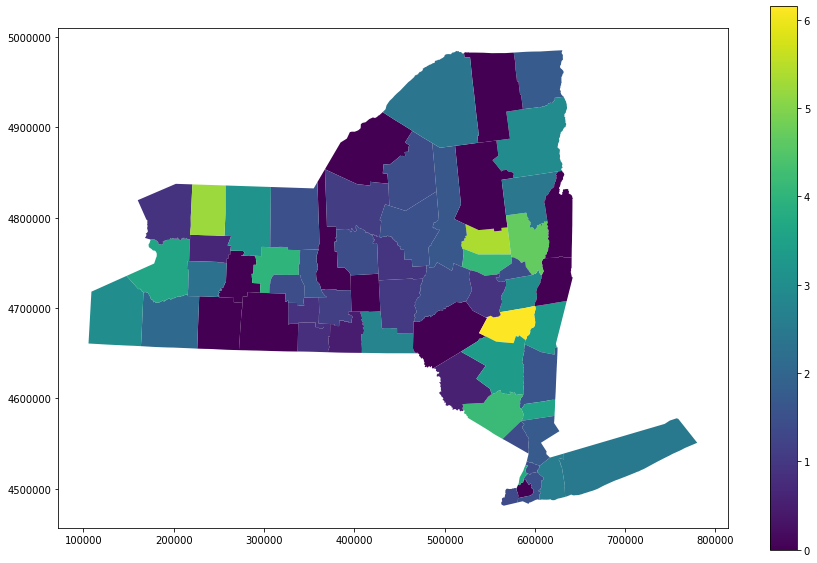

In [21]:
counties_shp.plot(column = 'r_naught', figsize=(15, 10), legend=True)

#### county health rankings dataset

In [22]:
county_rankings = pd.read_csv("us-county-health-rankings-2020.csv")
county_rankings = county_rankings[county_rankings.state=='New York']
county_rankings.sample(5)

,fips,state,county,num_deaths,years_of_potential_life_lost_rate,95percent_ci_low,95percent_ci_high,quartile,ypll_rate_aian,ypll_rate_aian_95percent_ci_low,...,percent_hispanic,num_non_hispanic_white,percent_non_hispanic_white,num_not_proficient_in_english,percent_not_proficient_in_english,95percent_ci_low_39,95percent_ci_high_39,percent_female,num_rural,percent_rural
1874,36027,New York,Dutchess,3166.0,5753.325522,5425.059072,6081.591972,1.0,NaN,NaN,...,12.484764,209066,71.179158,5837,2.082687,1.842229,2.323144,50.198149,75560.0,25.399344
1880,36039,New York,Greene,689.0,7900.349583,6911.474854,8889.224312,4.0,NaN,NaN,...,6.045356,40357,84.978206,391,0.857682,0.462088,1.253276,47.665874,36001.0,73.141545
1920,36119,New York,Westchester,7306.0,4257.651377,4105.425136,4409.877619,1.0,NaN,NaN,...,25.140346,513687,53.088118,57741,6.318053,6.027514,6.608592,51.559096,31069.0,3.273477
1912,36103,New York,Suffolk,14740.0,5813.785888,5667.325641,5960.246135,1.0,NaN,NaN,...,19.775261,995152,67.190379,56397,4.006396,3.796128,4.216665,50.771694,38844.0,2.601132
1885,36049,New York,Lewis,295.0,6932.577215,5675.248194,8189.906236,3.0,NaN,NaN,...,1.788483,25333,95.787802,132,0.526778,0.088268,0.965288,49.340190,23525.0,86.849780


In [23]:
#req_cols = ["fips","state","county","percent_fair_or_poor_health","average_number_of_physically_unhealthy_days","average_number_of_mentally_unhealthy_days","percent_smokers","percent_adults_with_obesity","percent_physically_inactive","percent_with_access_to_exercise_opportunities","percent_excessive_drinking","percent_uninsured","percent_vaccinated","high_school_graduation_rate","percent_some_college","percent_unemployed","percent_children_in_poverty","income_ratio","percent_single_parent_households","presence_of_water_violation","percent_severe_housing_problems","severe_housing_cost_burden","overcrowding","inadequate_facilities","percent_drive_alone_to_work","percent_long_commute_drives_alone","life_expectancy","percent_frequent_physical_distress","percent_adults_with_diabetes","percent_food_insecure","percent_limited_access_to_healthy_foods","percent_insufficient_sleep","median_household_income","percent_enrolled_in_free_or_reduced_lunch","percent_less_than_18_years_of_age","percent_65_and_over","percent_female"]
#req_cols = ["fips","state","county","percent_fair_or_poor_health","percent_smokers","percent_adults_with_obesity","percent_physically_inactive","percent_with_access_to_exercise_opportunities","percent_excessive_drinking","percent_vaccinated","high_school_graduation_rate","percent_some_college","percent_children_in_poverty","percent_single_parent_households","overcrowding","life_expectancy","percent_frequent_physical_distress","percent_adults_with_diabetes","percent_food_insecure","percent_limited_access_to_healthy_foods","percent_less_than_18_years_of_age","percent_65_and_over","percent_female"]
#req_cols = ["fips","state","county","percent_smokers","percent_adults_with_obesity","percent_physically_inactive","percent_vaccinated","overcrowding","life_expectancy","percent_adults_with_diabetes","percent_less_than_18_years_of_age","percent_65_and_over"]#,"percent_female"]

In [24]:
req_cols =  ["fips","state","county",'population', 'median_household_income',
       'percent_adults_with_obesity', 'percent_smokers', 'num_hiv_cases', 'percent_adults_with_diabetes', 
       'percent_with_access_to_exercise_opportunities', 'percent_some_college',
       'percent_unemployed', 'percent_children_in_poverty', 'percent_less_than_18_years_of_age',
       'percent_65_and_over', 'income_ratio', 'life_expectancy', 'overcrowding', 'food_environment_index',
        'percent_fair_or_poor_health'
       ]

In [25]:
set1_cols_38 = pd.merge(left=counties_shp,right=county_rankings[req_cols],left_on='FIPS_CODE',right_on='fips',how='left')
set1_cols_38.sample(5)

,NAME,FIPS_CODE,geometry,r_naught,infected_rate,fips,state,county,population,median_household_income,...,percent_some_college,percent_unemployed,percent_children_in_poverty,percent_less_than_18_years_of_age,percent_65_and_over,income_ratio,life_expectancy,overcrowding,food_environment_index,percent_fair_or_poor_health
10,Columbia,36021,"POLYGON ((633818.3433999997 4701636.998299999,...",3.345140,5.979810,36021,New York,Columbia,13007,64916.0,...,62.474052,3.318908,16.4,17.287536,23.791642,4.404203,79.642274,1.126705,8.5,13.717137
36,Orleans,36073,"POLYGON ((256280.6561000003 4781627.2382, 2562...",5.219653,4.394975,36073,New York,Orleans,10098,52658.0,...,53.297683,4.938692,17.6,19.348961,17.918349,3.951864,77.654238,1.983881,8.0,15.715650
13,Dutchess,36027,"POLYGON ((590247.7788000004 4659102.4684, 5902...",1.604566,1.615255,36027,New York,Dutchess,67685,79604.0,...,68.249982,3.685717,11.0,18.776173,17.579106,4.664684,80.571111,3.557737,8.6,14.696919
21,Herkimer,36043,"POLYGON ((486349.1716 4882668.3609, 486380.757...",1.666219,2.102342,36043,New York,Herkimer,13512,53168.0,...,59.976317,4.908896,20.1,20.628144,20.725179,4.151019,79.247035,1.499805,7.9,16.031261
15,Essex,36031,"POLYGON ((633423.4396000002 4930933.7017, 6334...",2.941176,2.523987,36031,New York,Essex,8808,54376.0,...,58.356040,4.883476,16.1,16.252011,23.439678,4.063817,80.821938,2.254902,8.7,11.420025


In [26]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [27]:
set1_cols_38.set_index('FIPS_CODE',inplace=True)
set1_cols_38.sample(5)

,NAME,geometry,r_naught,infected_rate,fips,state,county,population,median_household_income,percent_adults_with_obesity,...,percent_some_college,percent_unemployed,percent_children_in_poverty,percent_less_than_18_years_of_age,percent_65_and_over,income_ratio,life_expectancy,overcrowding,food_environment_index,percent_fair_or_poor_health
FIPS_CODE,,,,,,,,,,,,,,,,,,,,,
36079,Putnam,"POLYGON ((620790.7747999998 4598182.3605, 6210...",3.564510,3.110937,36079,New York,Putnam,22069,100887.0,23.2,...,69.237392,3.691886,6.6,19.809489,17.361364,4.028039,82.489353,1.876833,9.3,11.980605
36111,Ulster,"POLYGON ((583570.0048000002 4669036.086999999,...",3.377590,3.599280,36111,New York,Ulster,42727,63073.0,28.4,...,63.938493,3.891244,16.2,17.646795,19.780626,4.895628,79.816942,1.867744,8.1,15.933838
36043,Herkimer,"POLYGON ((486349.1716 4882668.3609, 486380.757...",1.666219,2.102342,36043,New York,Herkimer,13512,53168.0,32.0,...,59.976317,4.908896,20.1,20.628144,20.725179,4.151019,79.247035,1.499805,7.9,16.031261
36083,Rensselaer,"POLYGON ((628303.4359999998 4757411.532299999,...",0.000000,0.436230,36083,New York,Rensselaer,40495,71084.0,30.3,...,71.416224,3.891443,15.5,19.562600,16.953500,4.397278,78.976955,1.250885,8.2,15.017202
36009,Cattaraugus,"POLYGON ((169747.3399 4717358.9, 169915.500199...",2.082466,2.391511,36009,New York,Cattaraugus,16792,48017.0,37.6,...,56.038590,5.349794,24.4,22.036700,19.168402,4.446745,77.848799,2.269841,8.1,16.370700


#### heatmap of correlation of factors

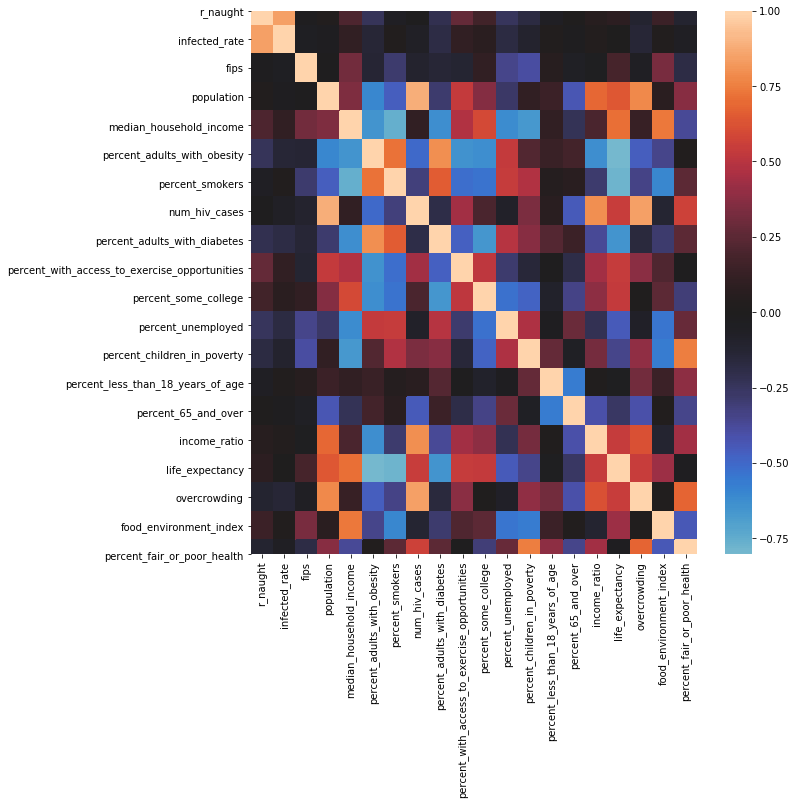

In [28]:
plt.figure(figsize = (10, 10))
sns.heatmap(set1_cols_38.corr(), center = 0)

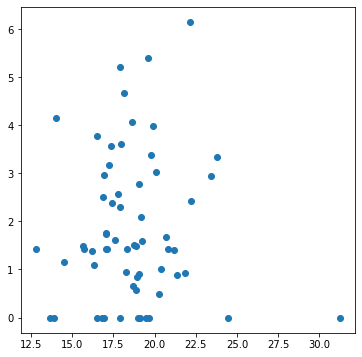

In [29]:
x = set1_cols_38['percent_65_and_over']
y = set1_cols_38['r_naught']
plt.figure(figsize = (6, 6))
plt.scatter(x, y)

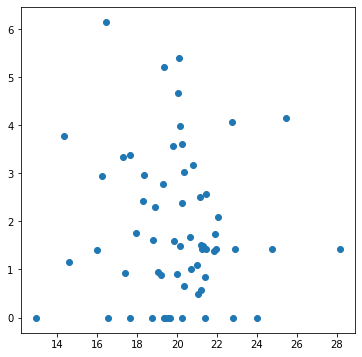

In [30]:
x = set1_cols_38['percent_less_than_18_years_of_age']
y = set1_cols_38['r_naught']
plt.figure(figsize = (6, 6))
plt.scatter(x, y)

## Not much correlation from the above two graphs

In [31]:
temp = county_rankings.copy()

In [32]:
temp = temp[['county', 'num_deaths']]

In [33]:
temp = temp.drop(index = 1860)

In [34]:
temp.num_deaths = temp.num_deaths.fillna(0)

In [35]:
temp = temp.sort_values(by = ['num_deaths'], ascending = False)

## Top 10 deaths by county

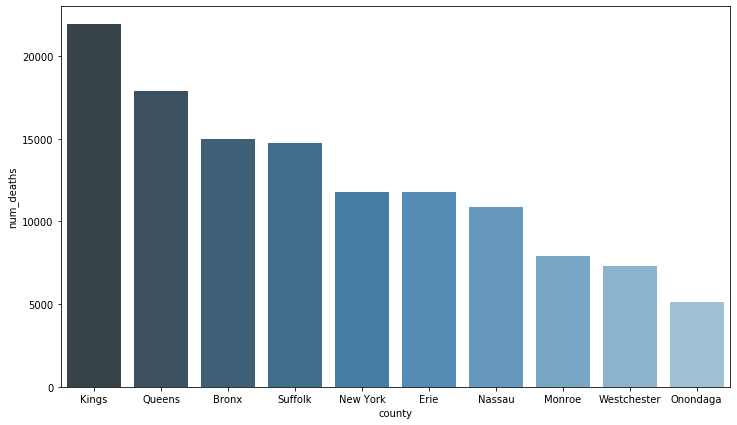

In [36]:
x_ = temp.iloc[:10]['county']
y_ = temp.iloc[:10]['num_deaths']
plt.figure(figsize =(12, 7))
sns.barplot(x_, y_, palette="Blues_d")

In [37]:
features = set1_cols_38.drop(['NAME','geometry','fips','state','county','r_naught','infected_rate'],1)

In [38]:
features = features.fillna(0)

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [41]:
labels = set1_cols_38.r_naught

#### linear regression model

In [42]:
x_train,x_test,y_train,y_test = train_test_split(features,labels,random_state=100,shuffle=True,test_size=0.2)

In [43]:
ridge = Ridge(alpha=0.0001)
ridge.fit(features, labels)
pred_r = ridge.predict(features)

In [44]:
r2_score(labels, pred_r)

0.33236628533740786

#### XgBoost model

In [45]:
from xgboost import XGBRegressor

In [46]:
xgb = XGBRegressor(reg_alpha=10)
_ = xgb.fit(features, labels.to_numpy())
pred_r = xgb.predict(features)

In [47]:
r2_score(labels, pred_r)

0.6249002436731185

In [93]:
xgb = XGBRegressor(reg_alpha=1000)
_ = xgb.fit(x_train, y_train.to_numpy())
pred_r = xgb.predict(x_test)
r2_score(y_test, pred_r)

-0.289300139785057

#### OLS model

In [48]:
import statsmodels.api as sm

model = sm.OLS(labels,features)
results = model.fit()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               r_naught   R-squared (uncentered):                   0.134
Model:                            OLS   Adj. R-squared (uncentered):             -0.193
Method:                 Least Squares   F-statistic:                             0.4100
Date:                Fri, 08 May 2020   Prob (F-statistic):                       0.976
Time:                        08:13:15   Log-Likelihood:                         -137.37
No. Observations:                  62   AIC:                                      308.7
Df Residuals:                      45   BIC:                                      344.9
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1474      0.986     -0.150      0.882      -2.132       1.838
x2            -0.2949      1.038     -0.284      0.778      -2.386       1.796
x3            -0.5638      0.991     -0.569      0.572      -2.560       1.432
x4             0.7162      0.732      0.978      0.333      -0.758       2.191
x5             1.1294      1.215      0.929      0.358      -1.319       3.577
x6            -0.5272      0.779     -0.676      0.502      -2.097       1.042
x7             0.6270      0.483      1.297      0.201      -0.347       1.601
x8            -0.5574      0.666     -0.837      0.407      -1.899       0.784
x9            -0.3301      0.514     -0.643      0.524      -1.365       0.705
x10           -0.7054      1.041     -0.678      0.501      -2.801       1.390
x11            0.5437      0.693      0.784      0.437      -0.852       1.940
x12            0.3213      0.645      0.498      0.621      -0.978       1.620
x13           -0.1603      0.872     -0.184      0.855      -1.917       1.596
x14           -0.0356      0.892     -0.040      0.968      -1.832       1.761
x15           -1.3121      1.168     -1.124      0.267      -3.664       1.040
x16            0.2401      0.681      0.353      0.726      -1.131       1.611
x17            0.5254      0.794      0.661      0.512      -1.075       2.126
==============================================================================
Omnibus:                       11.891   Durbin-Watson:                   0.627
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.337
Skew:                           0.932   Prob(JB):                      0.00209
Kurtosis:                       4.142   Cond. No.                         13.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [51]:
out = pca.transform(features)

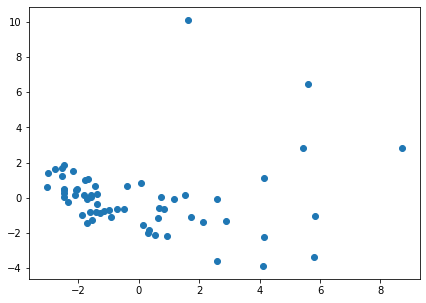

In [52]:
plt.figure(figsize = (7, 5))
plt.scatter(out[:, 0], out[:, 1])

#### Decision Tree Regressor

In [106]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth = 5)
clf.fit(features, labels)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [107]:
pred_y = clf.predict(features)

In [108]:
r2_score(labels, pred_y)

0.8036189445140806

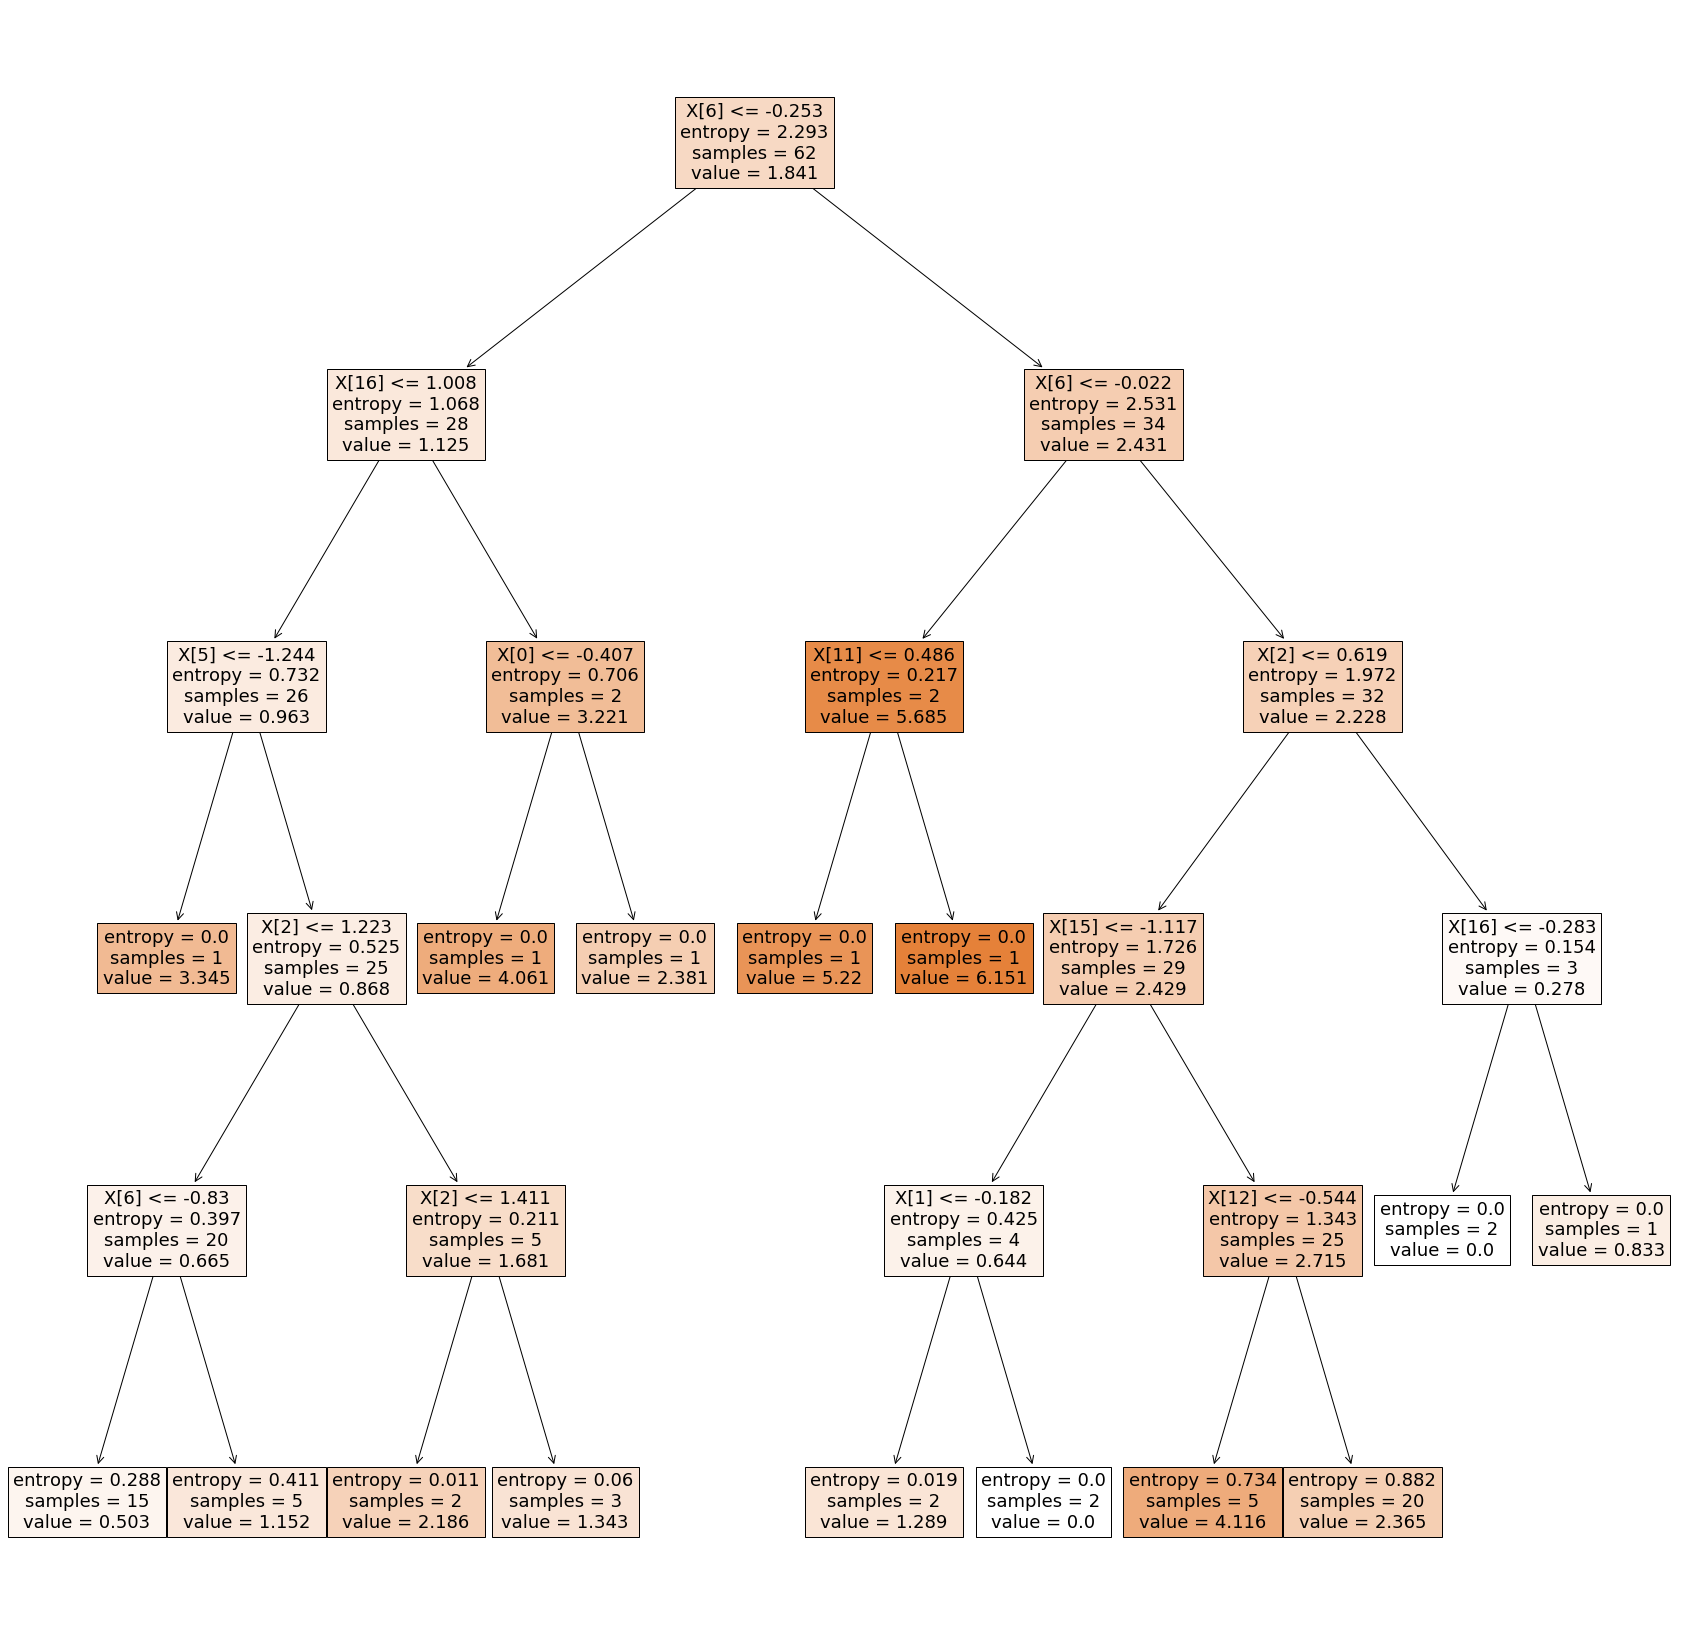

In [109]:
from sklearn import tree

plt.figure(figsize = (30, 30))
_ = tree.plot_tree(clf, filled = True)

#### Random Forest Regressor

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [95]:
rdm_clf = RandomForestRegressor(random_state=0)
_ = rdm_clf.fit(features, labels.to_numpy())
pred_r = rdm_clf.predict(features)
r2_score(labels,pred_r)

/root/shreeram/mlcity/skmob/lib64/python3.6/site-packages/scikit_learn-0.21.2-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.786929984856337

In [58]:
rdm_clf = RandomForestRegressor(random_state=0)
_ = rdm_clf.fit(features, labels.to_numpy())
pred_r = rdm_clf.predict(features)
r2_score(pred_r,labels)

/root/shreeram/mlcity/skmob/lib64/python3.6/site-packages/scikit_learn-0.21.2-py3.6-linux-x86_64.egg/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.5650389081134477

In [61]:
len(rdm_clf.feature_importances_)

17

In [63]:
clf_cols = ['population',
 'median_household_income',
 'percent_adults_with_obesity',
 'percent_smokers',
 'num_hiv_cases',
 'percent_adults_with_diabetes',
 'percent_with_access_to_exercise_opportunities',
 'percent_some_college',
 'percent_unemployed',
 'percent_children_in_poverty',
 'percent_less_than_18_years_of_age',
 'percent_65_and_over',
 'income_ratio',
 'life_expectancy',
 'overcrowding',
 'food_environment_index',
 'percent_fair_or_poor_health']

#### Feature importance of XgBoost model

In [66]:
len(xgb.feature_importances_)

17

In [74]:
x_score_dict = {}
for feature,imp in zip(clf_cols,xgb.feature_importances_):
    x_score_dict[feature] = imp * 100

In [76]:
x_score_dict = sorted(x_score_dict.items(),key=lambda x:x[1],reverse=True)

In [79]:
x_score_x = [ x[0] for x in x_score_dict]
x_score_y = [ float(x[1]) for x in x_score_dict]

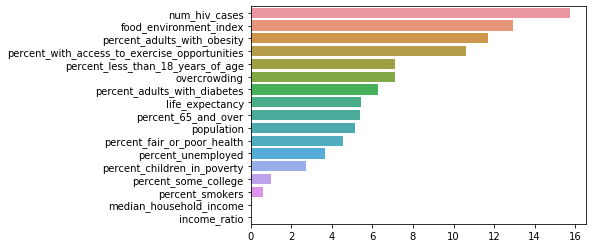

In [82]:
sns.barplot(x_score_y,x_score_x,orient="h")

#### Feature importance of Random Forest model

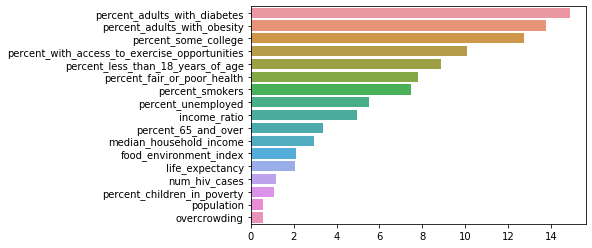

In [84]:
r_score_dict = {}
for feature,imp in zip(clf_cols,rdm_clf.feature_importances_):
    r_score_dict[feature] = imp * 100
r_score_dict = sorted(r_score_dict.items(),key=lambda x:x[1],reverse=True)
r_score_x = [ x[0] for x in r_score_dict]
r_score_y = [ float(x[1]) for x in r_score_dict]
sns.barplot(r_score_y,r_score_x,orient="h")